Привет, меня зовут Артем Носенко и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев.
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
Приношу свои извинения за долгую проверку твоего проекта. Это было связано с техническими проблемами на платформе проверки. 
Очень надеюсь, что такое больше не повторится.
</div>

# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import scipy
import numpy as np

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet("tracks.parquet")
catalog_names = pd.read_parquet("catalog_names.parquet")
interactions = pd.read_parquet("interactions.parquet")

In [4]:
catalog_names.dropna()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [6]:
# Развернем данные (раскроем списки артистов, альбомов, жанров)
tracks_exploded = tracks.explode('albums').explode('artists').explode('genres')

In [7]:
# в данных есть строки, в которыз не указан альбом, артист или жанр
tracks_exploded.isna().sum()

track_id        0
albums         18
artists     41789
genres      36675
dtype: int64

In [8]:
# Создание маски для строк, содержащих null значения в любом столбце
mask = tracks_exploded.isnull().any(axis=1)

# Получение значений столбца 'track_id' для таких строк
track_ids_with_nulls = set(list(tracks_exploded.loc[mask, 'track_id']))

In [9]:
# нет таких альбомов, о которых нет информации в каталоге
set(tracks_exploded['albums'].dropna()) - set(catalog_names[catalog_names['type']=='album']['id'])

set()

In [10]:
# в каталоге только те альбомы, которые есть в tracks
set(catalog_names[catalog_names['type']=='album']['id']) - set(tracks_exploded['albums'].dropna())

set()

In [11]:
# нет таких артистов, о которых нет информации в каталоге
set(tracks_exploded['artists'].dropna()) - set(catalog_names[catalog_names['type']=='artist']['id'])

set()

In [12]:
# в каталоге только те артисты, которые есть в tracks
set(catalog_names[catalog_names['type']=='artist']['id']) - set(tracks_exploded['artists'].dropna())

set()

In [13]:
# есть 30 жанров, которые встречаются в tracks, но отсутсвуют в каталоге
genres_exclude = list(set(tracks_exploded.dropna()['genres']) - set(catalog_names[catalog_names['type']=='genre']['id']))
len(genres_exclude)

30

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">
⚠️ Стоило вывести на печать эти жанры. Насколько много таких треков?

In [14]:
track_ids_with_no_genres = set(list(tracks_exploded[tracks_exploded['genres'].isin(genres_exclude)]['track_id']))

In [15]:
# есть 23 жанра, которые есть в каталоге, но отсутствуют в tracks
len(list(set(catalog_names[catalog_names['type']=='genre']['id']) - set(tracks_exploded['genres'].dropna())))

23

In [16]:
# исключим треки с пропусками в информации
items = tracks[~tracks['track_id'].isin(track_ids_with_no_genres | track_ids_with_nulls)]
items

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


# Выводы

В данных о некоторых треках отсутсвует информация об альбомах, артистах, жанрах.

Некоторые жанры, представленные в информации о треках, отсутсвуют в каталоге жанров

В датафрейме items были исключены треки, в которых отсутсвует информация об альбомах, артистах, жанрах, а также треки, жанры которых не представлены в каталоге


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Основные выводы сделаны! Отлично!
</div>

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

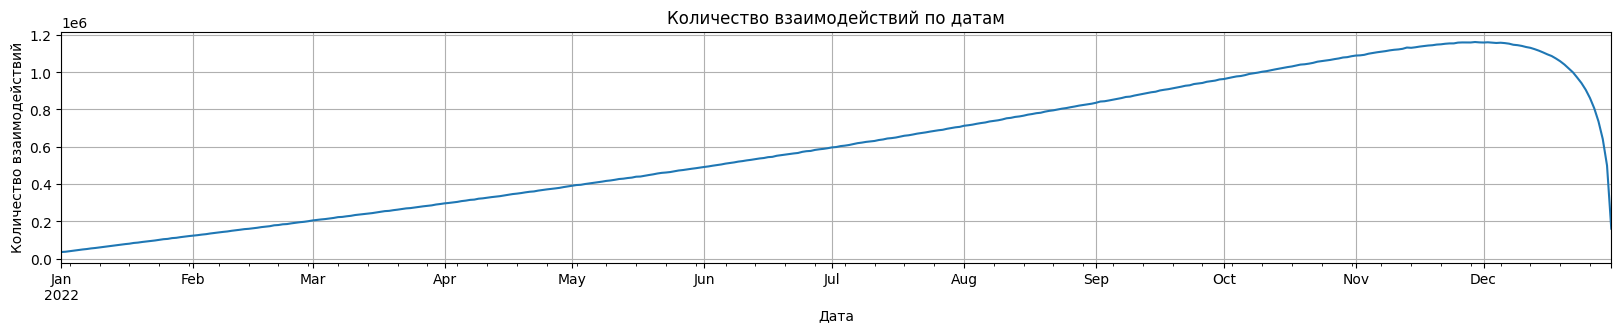

In [17]:
interaction_counts = interactions.groupby('started_at').size()

# Построение графика
plt.figure(figsize=(20, 3))
interaction_counts.plot(kind='line')
plt.title('Количество взаимодействий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество взаимодействий')
plt.grid(True)
plt.show()

Наиболее популярные треки

In [19]:
# топ-20 треков по кол-ву пользователей
interactions['track_id'].value_counts().head(20)

track_id
53404       111062
33311009    106921
178529      101924
35505245     99490
65851540     86670
24692821     86246
32947997     85886
51241318     85244
795836       85042
45499814     84748
60292250     84471
6705392      82483
39257277     81978
29544272     81057
37384        80153
51516485     78370
2758009      78181
47627256     76052
328683       75686
57921154     74733
Name: count, dtype: int64

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, распределение взаимодействий построено!
</div>

<div class="alert alert-warning">
⚠️ Возможно стоило добавить график распределения количества взаимодействий с треками. На нем можно было увидеть "длинный" хвост треков с малым количеством взаимодействий.

</div>

Наиболее популярные жанры

In [20]:
# топ-10 жанров в каталоге
items.explode('genres').merge(
    catalog_names[catalog_names['type']=='genre'], how='left', left_on='genres', right_on='id').rename(
        columns={"name":"genre_name"}).drop(columns=['id','type'])['genre_name'].value_counts().head(10)

genre_name
pop            166109
rap            128206
allrock        118461
electronics    106478
rusrap          65958
foreignrap      59772
rock            55148
dance           51595
ruspop          46706
alternative     42894
Name: count, dtype: int64

In [23]:
# топ-10 жанров по взаимодействиям
interactions.merge(items.explode('genres').merge(
    catalog_names[catalog_names['type']=='genre'], how='left', left_on='genres', right_on='id').rename(
        columns={"name":"genre_name"}).drop(columns=['id','type'])[['track_id', 'genre_name']], on = 'track_id')['genre_name'].value_counts().head(10)

genre_name
pop            55551134
rap            37799684
allrock        31085569
ruspop         26626234
rusrap         25303695
electronics    18376062
dance          16267222
rusrock        13166147
rock           12769694
foreignrap     12194520
Name: count, dtype: int64

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, у нас теперь есть распределение жанров по количеству взаимодействий!
</div>

Треки, которые никто не прослушал

In [24]:
tracks_not_listened = list(set(items['track_id']) - set(interactions['track_id']))
# len_tracks_not_listened = len(tracks_not_listened)
print(f"Кол-во непрослушанных треков: {len(tracks_not_listened)}")

Кол-во непрослушанных треков: 0


In [27]:
tracks_not_listed = list(set(interactions['track_id']) - set(items['track_id']))
print(f"Кол-во отсутсвующих треков: {len(tracks_not_listed)}")

Кол-во отсутсвующих треков: 67336


In [28]:
events = interactions[~interactions['track_id'].isin(tracks_not_listed)]

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Ок, такие треки удаляем. Видимо теперь мы их не сможем рекомендовать?
</div>

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [4]:
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["item_id"] = item_encoder.transform(items["track_id"])
items.head(3)

,track_id,albums,artists,genres,item_id
0,26,"[3, 2490753]",[16],"[11, 21]",0
1,38,"[3, 2490753]",[16],"[11, 21]",1
2,135,"[12, 214, 2490809]",[84],[11],2


In [5]:
events["item_id"] = item_encoder.transform(events["track_id"])
events.head(3)

,user_id,track_id,track_seq,started_at,item_id,user_id_enc
0,0,99262,1,2022-07-17,14842,0
1,0,589498,2,2022-07-19,55479,0
2,0,590262,3,2022-07-21,55952,0


In [6]:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events["user_id_enc"] = user_encoder.transform(events["user_id"])
events.head(3)

,user_id,track_id,track_seq,started_at,item_id,user_id_enc
0,0,99262,1,2022-07-17,14842,0
1,0,589498,2,2022-07-19,55479,0
2,0,590262,3,2022-07-21,55952,0


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [37]:
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, данные сохранены!
</div>

In [17]:
# Загрузка в S3
import boto3
import os
from dotenv import load_dotenv

load_dotenv()

session = boto3.session.Session()

bucket_name = os.getenv("S3_BUCKET_NAME")

ENDPOINT = "https://storage.yandexcloud.net"

session = boto3.Session(
    aws_access_key_id=(os.getenv("AWS_ACCESS_KEY_ID")),
    aws_secret_access_key=(os.getenv("AWS_SECRET_ACCESS_KEY")),
    region_name="ru-central1",
)

s3 = session.client(
    "s3", endpoint_url=ENDPOINT)

In [44]:
s3.upload_file('items.parquet', bucket_name, 'recsys/data/items.parquet')

In [46]:
s3.upload_file('events.parquet', bucket_name, 'recsys/data/events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [48]:
del tracks
del interactions

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [3]:
# зададим точку разбиения train-test
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [4]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = list(set(users_train) & set(users_test))

print(len(users_train), len(users_test), len(common_users))

1341269 778789 748016


In [9]:
cold_users = set(users_test) - set(users_train)

print(len(cold_users))

30773


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, выборки train / test сформированы. 

Выборки train / test можно получать несколькими способами (см. картинку ниже)
</div>

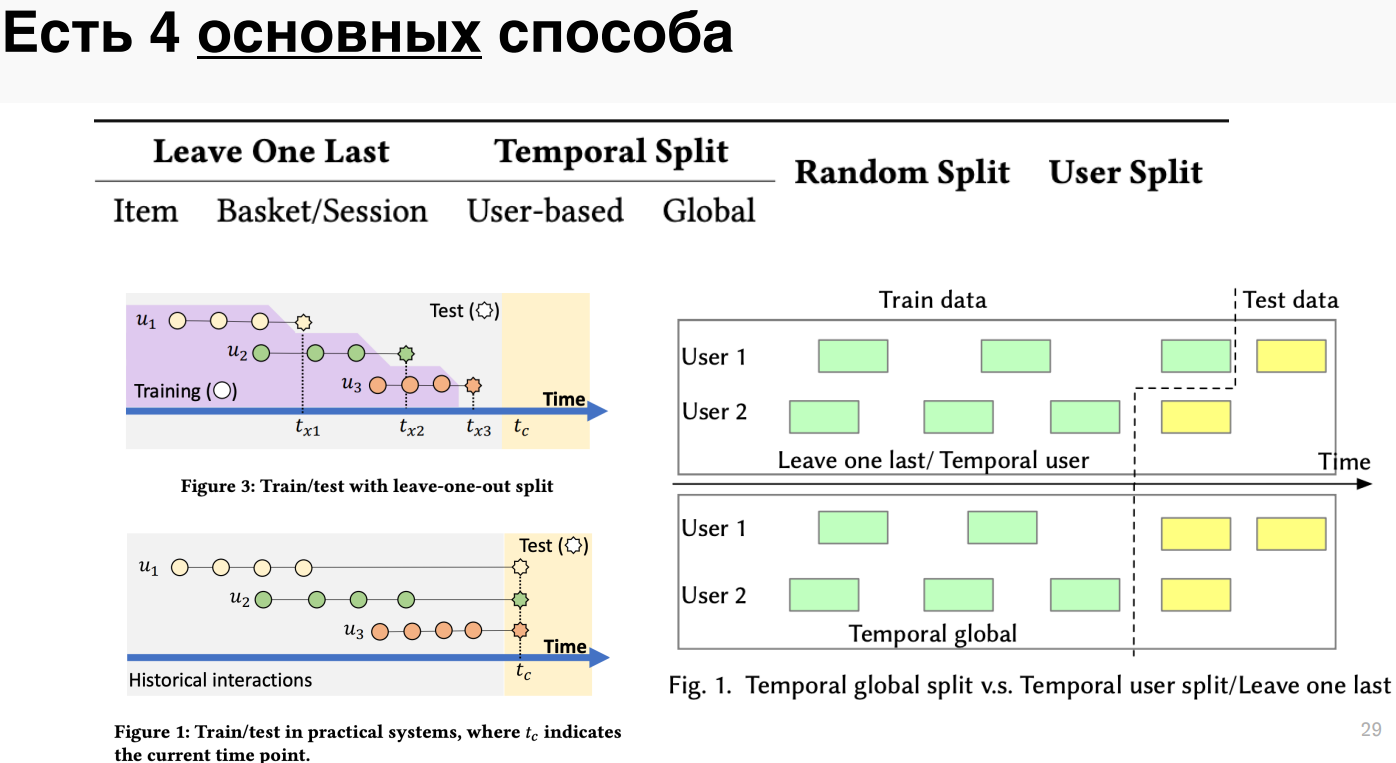

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [4]:
top_popular = events_train.groupby(['track_id', 'item_id']).agg(score=('user_id','nunique')).sort_values(by='score', ascending=False).reset_index().head(100)

In [5]:
top_popular.to_parquet("top_popular.parquet") 

In [19]:
# Не удалось загрузить, так как закончилась выделенная память
s3.upload_file('top_popular.parquet', bucket_name, 'recsys/recommendations/top_popular.parquet')

In [89]:
# top_popular.merge(catalog_names[catalog_names['type']=='track'], left_on = 'track_id', right_on = 'id')[['track_id', 'item_id', 'name', 'users']]

<b>Комментарий от ревьюера v1</b>


<div class="alert alert-warning">
⚠️ Жалко, что не получилось посчитать метрики для рекомендации популярных item

</div>

# Персональные

Рассчитаем персональные рекомендации.

In [6]:
# Исходя из имеющихся данных будем считать, что оценка треков, которые слушает пользователь как только заходит в сервис - выше
# Гипотеза заключается в том, что когда пользователь заходит на новый сервис, он в первую очередб слушает любимые треки.
events_train['rating'] = 1 / np.log(events_train['track_seq']+1)
events_test['rating'] = 1 / np.log(events_test['track_seq']+1)

/var/folders/_9/njpbnqcd29b4jbb06jpr0wgr0000gn/T/ipykernel_73073/3868804734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['rating'] = 1 / np.log(events_train['track_seq']+1)
/var/folders/_9/njpbnqcd29b4jbb06jpr0wgr0000gn/T/ipykernel_73073/3868804734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test['rating'] = 1 / np.log(events_test['track_seq']+1)


In [157]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id'])),
    dtype=np.int8) 

In [159]:
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 201204460 stored elements and shape (1372042, 932664)>

In [162]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=10, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

100%|██████████| 10/10 [08:24<00:00, 50.48s/it]


In [164]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=True, N=100)

In [166]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [172]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]].rename(columns={'item_id':'track_id'})
als_recommendations.to_parquet("als_recommendations.parquet") 

In [229]:
s3.upload_file('als_recommendations.parquet', bucket_name, 'recsys/recommendations/personal_als.parquet')

In [7]:
als_recommendations = pd.read_parquet("als_recommendations.parquet")

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, рекомендации получены!
</div>

# Похожие

In [12]:
item_ids_encoded = range(len(item_encoder.classes_))

In [212]:
# получаем рекомендации для всех пользователей
als_i2i_recommendations = als_model.similar_items(
    item_ids_encoded, N=100)

In [223]:
# преобразуем полученные рекомендации в табличный формат
i2i_item_ids_enc = als_i2i_recommendations[0]
i2i_als_scores = als_i2i_recommendations[1]

als_i2i_recommendations_df = pd.DataFrame({
    "item_ids_encoded": item_ids_encoded,
    "item_ids_recommended": i2i_item_ids_enc.tolist(), 
    "score": i2i_als_scores.tolist()})
als_i2i_recommendations_df = als_i2i_recommendations_df.explode(["item_ids_recommended", "score"], ignore_index=True)
als_i2i_recommendations_df


,item_ids_encoded,item_ids_recommended,score
0,0,0,1.0
1,0,274,0.609551
2,0,317,0.580747
3,0,459,0.571333
4,0,1918,0.54488
...,...,...,...
93266395,932663,806064,0.946117
93266396,932663,81944,0.946054
93266397,932663,781594,0.945983
93266398,932663,539673,0.945929


In [227]:
als_i2i_recommendations_df.to_parquet("similar.parquet") 

In [228]:
s3.upload_file('similar.parquet', bucket_name, 'recsys/recommendations/similar.parquet')

# Построение признаков

In [13]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-24")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

In [14]:
candidates = als_recommendations.rename(columns={"score":"als_score"})

In [15]:
candidates

,user_id,track_id,als_score
0,0,582507,9.093512e-07
1,0,59069,3.059669e-07
2,0,1177,2.268010e-07
3,0,4185,1.269922e-07
4,0,1123,1.120656e-07
...,...,...,...
137204195,1374582,1158,3.457694e-05
137204196,1374582,14207,3.405629e-05
137204197,1374582,15676,3.389577e-05
137204198,1374582,4215,3.216044e-05


In [18]:
events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "track_id", "target"]], 
                              on= ["user_id", "track_id"], how='left')
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [22]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)
candidates_to_sample

,user_id,track_id,als_score,target
30000,300,1628,2.967003e-07,0
30001,300,7435,2.272552e-07,0
30002,300,4185,1.996063e-07,0
30003,300,5570,1.217130e-07,0
30004,300,59069,1.074586e-07,0
...,...,...,...,...
137151795,1374057,979,1.123011e-05,0
137151796,1374057,7282,9.442289e-06,0
137151797,1374057,141,9.335310e-06,0
137151798,1374057,9572,9.067293e-06,0


In [32]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ]).reset_index(drop=True)

In [33]:
candidates_for_train

,user_id,track_id,als_score,target
0,300,560473,1.925466e-09,1
1,657,35505245,7.647262e-10,1
2,1300,29175370,1.196781e-11,1
3,1568,35505245,2.073397e-03,1
4,1603,29175370,4.451021e-09,1
...,...,...,...,...
16484,1373846,2019,6.820396e-07,0
16485,1374057,5991,1.321663e-03,0
16486,1374057,10366,2.425224e-05,0
16487,1374057,65765,1.202057e-02,0


In [34]:
candidates = als_recommendations.rename(columns={"score":"als_score"})


In [35]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates[candidates["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank)) 

77878900


In [38]:
events_labels.head()

,user_id,track_id,track_seq,started_at,item_id,user_id_enc,rating,target
32,3,78194999,33,2022-12-20,853840,3,0.283578,1
244,4,83375862,245,2022-12-18,878465,4,0.181642,1
245,4,83764704,246,2022-12-18,879981,4,0.181508,1
247,4,84099295,248,2022-12-21,881187,4,0.181243,1
248,4,84487963,249,2022-12-23,882577,4,0.181111,1


Построим три признака, можно больше, для ранжирующей модели.

In [40]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        tracks_listened=('track_seq', 'max'),
        rating_avg=("rating", "mean"))
    
    return user_features

In [41]:
# Вместе с оценкой ALS получается три признака
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

In [46]:
# оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

user_features_for_ranking = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on="user_id", how="left")

In [48]:
candidates_for_train

,user_id,track_id,als_score,target,tracks_listened,rating_avg
0,300,560473,1.925466e-09,1,9.0,0.681993
1,657,35505245,7.647262e-10,1,34.0,0.422257
2,1300,29175370,1.196781e-11,1,9.0,0.681993
3,1568,35505245,2.073397e-03,1,47.0,0.385694
4,1603,29175370,4.451021e-09,1,20.0,0.507848
...,...,...,...,...,...,...
16484,1373846,2019,6.820396e-07,0,121.0,0.287807
16485,1374057,5991,1.321663e-03,0,56.0,0.359079
16486,1374057,10366,2.425224e-05,0,56.0,0.359079
16487,1374057,65765,1.202057e-02,0,56.0,0.359079


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ ОК!

</div>

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [49]:
from catboost import CatBoostClassifier, Pool

# задаём имена колонок признаков и таргета
features = ['als_score', 'tracks_listened', 'rating_avg']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

Learning rate set to 0.034094
0:	learn: 0.6810515	total: 61.1ms	remaining: 1m 1s
1:	learn: 0.6700082	total: 63.3ms	remaining: 31.6s
2:	learn: 0.6595617	total: 66.3ms	remaining: 22s
3:	learn: 0.6498967	total: 69.1ms	remaining: 17.2s
4:	learn: 0.6409594	total: 71.9ms	remaining: 14.3s
5:	learn: 0.6326867	total: 75.9ms	remaining: 12.6s
6:	learn: 0.6250483	total: 79.4ms	remaining: 11.3s
7:	learn: 0.6178676	total: 83.2ms	remaining: 10.3s
8:	learn: 0.6110284	total: 86.3ms	remaining: 9.5s
9:	learn: 0.6047196	total: 89.3ms	remaining: 8.84s
10:	learn: 0.5989574	total: 91.6ms	remaining: 8.24s
11:	learn: 0.5936952	total: 94ms	remaining: 7.74s
12:	learn: 0.5887489	total: 96.8ms	remaining: 7.35s
13:	learn: 0.5841805	total: 99.6ms	remaining: 7.02s
14:	learn: 0.5798449	total: 103ms	remaining: 6.76s
15:	learn: 0.5759296	total: 106ms	remaining: 6.5s
16:	learn: 0.5722129	total: 109ms	remaining: 6.28s
17:	learn: 0.5687889	total: 112ms	remaining: 6.09s
18:	learn: 0.5656906	total: 115ms	remaining: 5.93s
19:

In [50]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

In [54]:
candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1

max_recommendations_per_user = 100
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

In [62]:
# Формирование списка файлов для удаления
file_keys = []
for key in s3.list_objects(Bucket=bucket_name)['Contents']:
    if 'recsys' not in key['Key']:
        file_keys.append(key['Key'])

objects_to_delete = [{'Key': key} for key in file_keys]
response = s3.delete_objects(Bucket=bucket_name, Delete={'Objects': objects_to_delete})

In [65]:
final_recommendations.to_parquet("recommendations.parquet")


In [95]:
final_recommendations

,user_id,track_id,als_score,tracks_listened,rating_avg,cb_score,rank
8,3,5991,3.323734e-06,33.0,0.426530,0.437354,1
0,3,4203,2.540093e-05,33.0,0.426530,0.362762,2
73,3,3853,1.416903e-08,33.0,0.426530,0.291634,3
74,3,2420,1.402615e-08,33.0,0.426530,0.291634,4
99,3,43115,1.881525e-09,33.0,0.426530,0.284293,5
...,...,...,...,...,...,...,...
77878875,1374582,7786,8.971454e-05,252.0,0.236949,0.105233,96
77878876,1374582,861,8.840568e-05,252.0,0.236949,0.105233,97
77878889,1374582,81561,5.075739e-05,252.0,0.236949,0.103379,98
77878890,1374582,9288,5.025520e-05,252.0,0.236949,0.103379,99


In [68]:
# Не удалось загрузить, так как закончилась выделенная память
s3.upload_file('recommendations.parquet', bucket_name, 'recsys/recommendations/recommendations.parquet')

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

### Расчёт Recall и Precision

In [12]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [85]:
# для ALS
events_recs_for_binary_metrics_als = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    als_recommendations, 
    top_k=100) 

/var/folders/_9/njpbnqcd29b4jbb06jpr0wgr0000gn/T/ipykernel_60576/2198150141.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 778789


In [86]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

# Получаем precision@100 и recall@100 для als
compute_cls_metrics(events_recs_for_binary_metrics_als)

(5.805166739643216e-05, 0.00048152820915601505)

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">

⚠️ Метрики выглядят достаточно небольшими. Возможно где-то закралась ошибка.\
Стоит проверить чему будут равны метрики для случайной рекомендации.

</div>

In [13]:
events_recs_for_binary_metrics_top = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    events_test[['user_id']].drop_duplicates().merge(top_popular[['track_id','score']], how='cross'), # для каждого юзера подбираем 100 популярных треков
    top_k=100)

/var/folders/_9/njpbnqcd29b4jbb06jpr0wgr0000gn/T/ipykernel_73073/2198150141.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 778789


In [15]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

# Получаем precision@100 и recall@100 для top-100
compute_cls_metrics(events_recs_for_binary_metrics_top)

(0.004522341738262868, 0.03424776794444274)

In [97]:
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

cb_events_recs_for_binary_metrics_rank = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=100)

# Получаем precision@100 и recall@100 для ранжированной модели
compute_cls_metrics(cb_events_recs_for_binary_metrics_rank)

Common users: 567159


(1.5798038997882428e-05, 0.00033463207193339134)

### Coverage

In [105]:
# расчёт покрытия по объектам топ-100
cov_items = 100 / events_test['item_id'].nunique()
print(f"{cov_items:.4f}") 

0.0002


In [104]:
# расчёт покрытия по объектам ALS
cov_items = als_recommendations['track_id'].nunique() / events_test['item_id'].nunique()
print(f"{cov_items:.4f}") 

0.0013


In [107]:
# расчёт покрытия по объектам Rank
cov_items = final_recommendations['track_id'].nunique() / events_test_2['item_id'].nunique()
print(f"{cov_items:.4f}") 

0.0019


### Novelty

Новизна для ALS и Rank будет равна 1, так как при обучении модели ALS был выбран параметр "не предлагать прослушенные треки"

In [8]:
# Посчитаем новизну для рекомендаций топ-100 треков
events_train["listened"] = True
top_novelty = events_train[['user_id']].drop_duplicates().merge(top_popular[['track_id','score']], how='cross').merge(events_train, on=['user_id', 'track_id'], how='left')
top_novelty["listened"] = top_novelty["listened"].fillna(False).astype("bool")

# посчитаем novelty по пользователям
novelty = (1-top_novelty.groupby("user_id")["listened"].mean())

# посчитаем средний novelty
novelty.mean()

/var/folders/_9/njpbnqcd29b4jbb06jpr0wgr0000gn/T/ipykernel_73073/2660071246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["listened"] = True


0.9543987969601926

# === Выводы, метрики ===

В ходе работы были рассмотрены и оценены три вида рекомендаций:
- топ-100 рекомендаций
- ALS
- Ранжирующая модель с использованием результатов ALS и дополнительных признаков пользователей

#### ТОП-100
Recall@100: 0.0342

Precision@100: 0.0045

Coverage: 0.0002

Novelty 0.954

Метрики классификации Precision и Recall более высокие относительно других, Coverage ожидаемо низкий, так как 100 треков - это лишь малая доля всех доступных треков. Novelty получился достаточно высоким.

#### ALS
Recall@100: 0.0005

Precision@100: 0.00005

Coverage: 0.0013

Novelty: 1

Метрики классификации Precision и Recall оказались гораздо ниже по сравнению с базовыми топ-100 рекомендациями. Coverage на порядок выше относительно топ-100. Novelty получился равным 1, так как при построении модели был использован параметр, который позволяет не рекомендовать треки, которые уже были прослушаны.

#### Rank
Recall@100: 0.0003

Precision@100: 0.00001

Coverage: 0.0019

Novelty: 1

Метрики классификации Precision и Recall оказались гораздо ниже по сравнению с базовыми топ-100 рекомендациями. Coverage на порядок выше относительно топ-100, получилось увеличить этот показатель относительно ALS с помощью Rank модели. Novelty получился равным 1, так как при построении модели был использован параметр, который позволяет не рекомендовать треки, которые уже были прослушаны.

<b>Комментарий от ревьюера v1</b>


    
# Общий вывод
<div class="alert alert-block alert-success">

Спасибо за работу, у тебя получился хороший проект. Удалось протестировать различные алгоритмы для формирования рекомендаций. 
Есть небольшие замечания. Просьба ознакомиться с ними и учитывать в дальнейшей работе.
Так как ты долго ждал и проверка затянулась по техническим причинам, я готов принять твой проект.
Если у тебя нет ко мне вопросов - отправляй проект обратно и я его приму!

Если есть вопросы или желание улучшить твой проект - оставь вопросы комментарии после этой ячейки. Постараюсь тебе помочь с ответами и улучшением твоего проекта!
</div>


<div class="alert alert-block alert-info">
<b>Артем, большое спасибо за проверку! Замечания учту)</b> 
</div>